In [ ]:
#Emptying the Cache memory present in the CUDA
import torch
torch.cuda.empty_cache()

## Importing the necessary packages and initialising various parameters ##
import torch
import os
from torch.utils.data import Dataset
import cv2
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.io import imread, imsave
from skimage.transform import resize
import torchvision
import torchvision.transforms.functional as G
from google.colab.patches import cv2_imshow
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils import model_zoo
from torchvision import models
from torch.optim.lr_scheduler import StepLR

# Initializing learning rate, number of epochs to train and the batch size
Learning_rate= 0.001
Number_of_epochs = 5
Batch_size = 2

#Define the test split
Test_split= 0.15

#Determine the device to be used for training and evaluation
Device= "cuda" if torch.cuda.is_available() else "cpu"
print(Device)

cuda


In [ ]:
## Dataset loading ##


# Transformations of the image to desired size and convert to tensor
transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256)),transforms.ToTensor()])

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):
		imagePath = self.imagePaths[idx]  # grab the image path from the current index
		maskPath=self.maskPaths[idx]
		image = cv2.imread(imagePath)
		mask = cv2.imread(maskPath,0)
	 # check to see if we are applying any transformations
		if self.transforms is not None:
			image = self.transforms(image) # apply the transformations to both image and its mask
			mask = self.transforms(mask)
		return (image, mask)


# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/IIIT /Leaf_Disease/data/data/images')))
maskPaths = sorted(list(paths.list_images('/content/drive/MyDrive/IIIT /Leaf_Disease/data/data/masks')))
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,test_size=0.15, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]


# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,batch_size=Batch_size)
testLoader = DataLoader(testDS, shuffle=False,batch_size=Batch_size)

[INFO] found 499 examples in the training set...
[INFO] found 89 examples in the test set...


Training the network...


 20%|██        | 1/5 [03:19<13:16, 199.13s/it]

Epoch: 1/5
Train Dice Loss: 0.8921, Test Dice Loss: 0.9035, IOU Loss: 0.9413 


 40%|████      | 2/5 [04:03<05:23, 107.94s/it]

Epoch: 2/5
Train Dice Loss: 0.8744, Test Dice Loss: 0.9215, IOU Loss: 0.9310 


 60%|██████    | 3/5 [04:46<02:36, 78.44s/it] 

Epoch: 3/5
Train Dice Loss: 0.8695, Test Dice Loss: 0.8725, IOU Loss: 0.9283 


 80%|████████  | 4/5 [05:30<01:04, 64.90s/it]

Epoch: 4/5
Train Dice Loss: 0.8614, Test Dice Loss: 0.9026, IOU Loss: 0.9236 


100%|██████████| 5/5 [06:14<00:00, 74.82s/it]

Epoch: 5/5
Train Dice Loss: 0.8551, Test Dice Loss: 0.8818, IOU Loss: 0.9202 
[INFO] total time taken to train the model: 374.10s


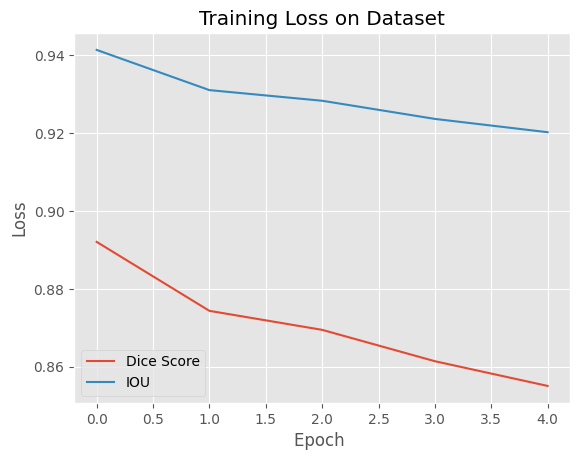

In [ ]:
# Model Number 1 UNet

import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits=torch.sigmoid(logits)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


class DiceLoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1-(2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice_loss

class IoULoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU



## Running the Model ##

#For calculating the average loss
trainSteps = len(trainDS) // Batch_size
testSteps = len(testDS) // Batch_size
# Initializing the UNet model
UNet = UNet(3,1).to(Device)
# Initializing Loss function and Optimizer
DiceFunc=DiceLoss()
IoUFunc=IoULoss()
optimizer = Adam(UNet.parameters(), lr=Learning_rate)
# initialize a dictionary to store training history
H = {"Dice_Loss": [] , "IOU_Loss": []}
print("Training the network...")
startTime = time.time()


for e in tqdm(range(Number_of_epochs)):
  UNet.train()
  Total_Train_Dice_Loss=0
  Total_Test_Dice_Loss=0
  Total_IoU_Loss=0
  for (i, (x, y)) in enumerate(trainLoader):
    (x, y) = (x.to(Device), y.to(Device))
    #print('X=\n',x.shape)
    #print('Y=\n',y.shape)
    prediction = UNet(x)
    Train_Dice_Loss=DiceFunc(prediction,y)
    IoU_Loss=IoUFunc(prediction,y)
    Total_IoU_Loss+=IoU_Loss
    Total_Train_Dice_Loss+=Train_Dice_Loss
    optimizer.zero_grad()
    Train_Dice_Loss.backward()
    optimizer.step()
    #scheduler.step()

  with torch.no_grad():
    UNet.eval()
    for (x, y) in testLoader:
      (x, y) = (x.to(Device), y.to(Device))
      pred = UNet(x)
      Test_Dice_Loss=0
      Test_Dice_Loss=DiceFunc(pred,y)
      Total_Test_Dice_Loss+=Test_Dice_Loss

  avgTrainLoss = Total_Train_Dice_Loss / trainSteps
  avgTestLoss = Total_Test_Dice_Loss / testSteps
  avgIoULoss=Total_IoU_Loss /trainSteps

	# update our training history
  H["Dice_Loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["IOU_Loss"].append(avgIoULoss.cpu().detach().numpy())
  # print the model training and validation information
  print("Epoch: {}/{}".format(e + 1, Number_of_epochs))
  print("Train Dice Loss: {:.4f}, Test Dice Loss: {:.4f}, IOU Loss: {:.4f} ".format(avgTrainLoss,avgTestLoss,avgIoULoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))


## Plotting the training loss ##

plt.style.use("ggplot")
plt.figure()
plt.plot(H["Dice_Loss"], label="Dice Score")
plt.plot(H["IOU_Loss"], label="IOU")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")


Max= tensor(1., device='cuda:0')
Min= tensor(4.1692e-11, device='cuda:0')
Image


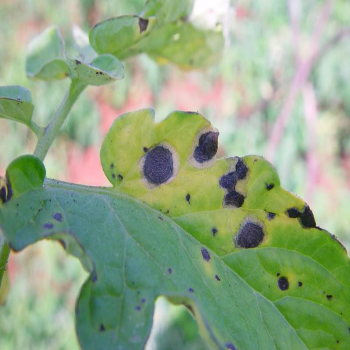

Ground Truth


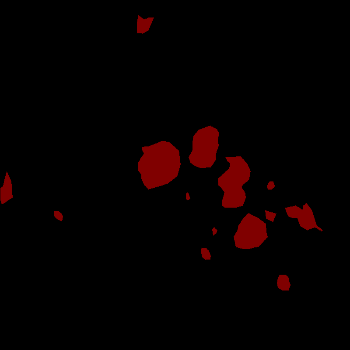

Predicted Mask


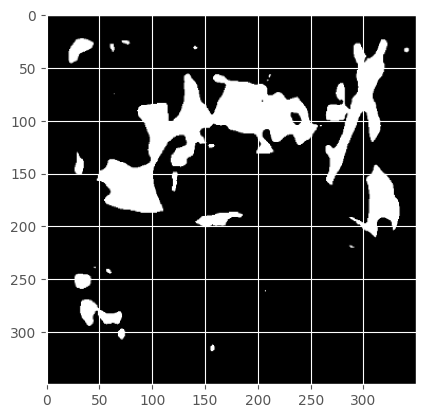

In [ ]:
#define augmentations
inference_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((520,520)),transforms.ToTensor()])

#define function for predictions
def predict(model, img, device):
    model.eval()
    with torch.no_grad():
        images = img.to(device)
        output = model(images)
        print('Max=',torch.max(output))
        print('Min=',torch.min(output))
        predicted_masks = (output.squeeze() >= 0.5).float().cpu().numpy()

    return(predicted_masks)

#define function to load image and output mask
def get_mask(img_path):
    image = cv2.imread(img_path)

    image_trans = inference_transform(image)
    image_trans = image_trans.unsqueeze(0)
    image_mask = predict(UNet, image_trans, Device)

    return(image_mask)

#image example

Image_path = '/content/drive/MyDrive/IIIT /Leaf_Disease/data/data/images/00005.jpg'
Image = cv2.imread(Image_path)
Image = cv2.resize(Image, (350,350))

Ground_truth_path= '/content/drive/MyDrive/IIIT /Leaf_Disease/data/data/masks/00005.png'
Ground_truth= cv2.imread(Ground_truth_path)
Ground_truth = cv2.resize(Ground_truth, (350,350))

predicted_mask = get_mask(Image_path)
predicted_mask = cv2.resize(predicted_mask, (350,350))

print('Image')
cv2_imshow(Image)

print('Ground Truth')
cv2_imshow(Ground_truth)

print('Predicted Mask')
predicted=np.where(predicted_mask>0.5,1,0)
plt.imshow(predicted_mask,cmap='gray')
#plt.imshow(np.hstack((Image,Ground_truth,predicted_mask)))

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=2):
    DeepLabv3 = models.segmentation.deeplabv3_resnet101(pretrained=True,progress=True)
    DeepLabv3.classifier = DeepLabHead(204, outputchannels)
    # Set the model in training mode
    DeepLabv3.train()
    return DeepLabv3

class DiceLoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1-(2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice_loss

class IoULoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU



## Running the Model ##

#For calculating the average loss
trainSteps = len(trainDS) // Batch_size
testSteps = len(testDS) // Batch_size
# Initializing the DeepLAbv3+ model
DeepLabv3 = DeepLabv3.to(Device)
# Initializing Loss function and Optimizer
DiceFunc=DiceLoss()
IoUFunc=IoULoss()
optimizer = Adam(DeepLabv3.parameters(), lr=Learning_rate)
# initialize a dictionary to store training history
H = {"Dice_Loss": [] , "IOU_Loss": []}
print("Training the network...")
startTime = time.time()


for e in tqdm(range(Number_of_epochs)):
  DeepLabv3.train()
  Total_Train_Dice_Loss=0
  Total_Test_Dice_Loss=0
  Total_IoU_Loss=0
  for (i, (x, y)) in enumerate(trainLoader):
    (x, y) = (x.to(Device), y.to(Device))
    prediction = DeepLabv3(x)
    prediction = prediction["out"]
    Train_Dice_Loss=DiceFunc(prediction,y)
    IoU_Loss=IoUFunc(prediction,y)
    Total_IoU_Loss+=IoU_Loss
    Total_Train_Dice_Loss+=Train_Dice_Loss
    optimizer.zero_grad()
    Train_Dice_Loss.backward()
    optimizer.step()
    #scheduler.step()

  with torch.no_grad():
    DeepLabv3.eval()
    for (x, y) in testLoader:
      (x, y) = (x.to(Device), y.to(Device))
      pred = DeepLabv3(x)
      Test_Dice_Loss=0
      Test_Dice_Loss=DiceFunc(pred,y)
      Total_Test_Dice_Loss+=Test_Dice_Loss

  avgTrainLoss = Total_Train_Dice_Loss / trainSteps
  avgTestLoss = Total_Test_Dice_Loss / testSteps
  avgIoULoss=Total_IoU_Loss /trainSteps

	# update our training history
  H["Dice_Loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["IOU_Loss"].append(avgIoULoss.cpu().detach().numpy())
  # print the model training and validation information
  print("Epoch: {}/{}".format(e + 1, Number_of_epochs))
  print("Train Dice Loss: {:.4f}, Test Dice Loss: {:.4f}, IOU Loss: {:.4f} ".format(avgTrainLoss,avgTestLoss,avgIoULoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))


## Plotting the training loss ##

plt.style.use("ggplot")
plt.figure()
plt.plot(H["Dice_Loss"], label="Dice Score")
plt.plot(H["IOU_Loss"], label="IOU")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")

AttributeError: ignored

In [ ]:
# Model Number 3 FPN

import torch
import torch.nn as nn
import torch.nn.functional as F

class FPN(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FPN, self).__init__()

        # Lateral Convolutions
        self.lateral_convs = nn.ModuleList()
        for in_channels in in_channels_list[::-1]:
            lateral_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
            self.lateral_convs.insert(0, lateral_conv)

        # Top-down Convolutions
        self.topdown_convs = nn.ModuleList()
        for i in range(len(in_channels_list)-1):
            topdown_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.topdown_convs.append(topdown_conv)

        # Bottom-up Convolutions
        self.bottomup_convs = nn.ModuleList()
        for i in range(len(in_channels_list)-1):
            bottomup_conv = nn.Conv2d(in_channels_list[i+1], out_channels, kernel_size=1)
            self.bottomup_convs.append(bottomup_conv)

        # Final Convolutions
        self.final_convs = nn.ModuleList()
        for i in range(len(in_channels_list)):
            final_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            self.final_convs.append(final_conv)

    def forward(self, inputs):
        laterals = [lateral_conv(inputs[-1])]
        for i in range(len(inputs)-2, -1, -1):
            laterals.insert(0, lateral_conv(inputs[i]))
            laterals[0] = F.interpolate(laterals[0], scale_factor=2, mode='nearest')
            laterals[0] += self.bottomup_convs[i](inputs[i])

        features = laterals[0]
        for i in range(len(inputs)-1):
            features = self.topdown_convs[i](features)
            features = F.interpolate(features, scale_factor=2, mode='nearest')
            features += laterals[i+1]

        outputs = []
        for i in range(len(inputs)):
            output = self.final_convs[i](features)
            outputs.append(output)
        return outputs

class DiceLoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1-(2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice_loss

class IoULoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU



## Running the Model ##

#For calculating the average loss
trainSteps = len(trainDS) // Batch_size
testSteps = len(testDS) // Batch_size
# Initializing the UNet model
FPN = FPN(3,1).to(Device)
# Initializing Loss function and Optimizer
DiceFunc=DiceLoss()
IoUFunc=IoULoss()
optimizer = Adam(FPN.parameters(), lr=Learning_rate)
# initialize a dictionary to store training history
H = {"Dice_Loss": [] , "IOU_Loss": []}
print("Training the network...")
startTime = time.time()


for e in tqdm(range(Number_of_epochs)):
  FPN.train()
  Total_Train_Dice_Loss=0
  Total_Test_Dice_Loss=0
  Total_IoU_Loss=0
  for (i, (x, y)) in enumerate(trainLoader):
    (x, y) = (x.to(Device), y.to(Device))
    #print('X=\n',x.shape)
    #print('Y=\n',y.shape)
    prediction = FPN(x)
    Train_Dice_Loss=DiceFunc(prediction,y)
    IoU_Loss=IoUFunc(prediction,y)
    Total_IoU_Loss+=IoU_Loss
    Total_Train_Dice_Loss+=Train_Dice_Loss
    optimizer.zero_grad()
    Train_Dice_Loss.backward()
    optimizer.step()
    #scheduler.step()

  with torch.no_grad():
    UNet.eval()
    for (x, y) in testLoader:
      (x, y) = (x.to(Device), y.to(Device))
      pred = FPN(x)
      Test_Dice_Loss=0
      Test_Dice_Loss=DiceFunc(pred,y)
      Total_Test_Dice_Loss+=Test_Dice_Loss

  avgTrainLoss = Total_Train_Dice_Loss / trainSteps
  avgTestLoss = Total_Test_Dice_Loss / testSteps
  avgIoULoss=Total_IoU_Loss /trainSteps

	# update our training history
  H["Dice_Loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["IOU_Loss"].append(avgIoULoss.cpu().detach().numpy())
  # print the model training and validation information
  print("Epoch: {}/{}".format(e + 1, Number_of_epochs))
  print("Train Dice Loss: {:.4f}, Test Dice Loss: {:.4f}, IOU Loss: {:.4f} ".format(avgTrainLoss,avgTestLoss,avgIoULoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))


## Plotting the training loss ##

plt.style.use("ggplot")
plt.figure()
plt.plot(H["Dice_Loss"], label="Dice Score")
plt.plot(H["IOU_Loss"], label="IOU")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")


TypeError: ignored